In [1]:
!pip install tensorflow gensim


In [14]:
import os
import gensim
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.api.models import Sequential
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras.preprocessing.text import Tokenizer
from keras.api.preprocessing.sequence import pad_sequences
from keras.api.layers import Embedding, LSTM, Dense, Dropout

In [3]:
# Define the path to the zip file and the extraction directory
zip_file_path = '/content/archive (2).zip'
extract_dir = 'dataset'

# Check if the extraction directory exists, create it if it doesn't
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted all files to {extract_dir}")


Extracted all files to dataset


In [4]:
# Load your dataset
df = pd.read_csv('/content/dataset/WELFake_Dataset.csv')

# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'title'])

# Drop rows with missing values
df = df.dropna()

# Display the first few rows of the dataframe
print(df.head())

# Print the shape of the dataframe (number of rows and columns)
print(df.shape)

# Display information about the dataframe, including the data types and non-null counts
print(df.info())


                                                text  label
0  No comment is expected from Barack Obama Membe...      1
1     Did they post their votes for Hillary already?      1
2   Now, most of the demonstrators gathered last ...      1
3  A dozen politically active pastors came here f...      0
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1
(72095, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 72095 entries, 0 to 72133
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    72095 non-null  object
 1   label   72095 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB
None


In [5]:
# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)


In [6]:
# Tokenize the training texts
tokenized_texts = [text.split() for text in train_texts]

# Train a Word2Vec model
word2vec_model = gensim.models.Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(tokenized_texts, total_examples=len(tokenized_texts), epochs=10)


(254972428, 312236900)

In [7]:
# Tokenize the texts
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_texts)

# Create a word index
word_index = tokenizer.word_index

# Create the embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [29]:
# Display the embedding sample
print("Embedding sample:\n", embedding_matrix[4])

Embedding sample:
 [ 1.25150275 -0.99795252 -1.15786242 -2.1520257   3.06177998 -0.80194759
  0.68081528 -1.7429837  -1.00954306  1.76122212 -1.14428687 -2.14934349
  0.0843183   0.57425445 -0.70069969  1.10399318  1.72164583  1.77754414
  0.52756715  1.21605229  0.87046915  0.80610788  0.5854671  -2.07647967
  4.89709282  1.53724623  2.85775399  1.82533276 -2.4212873  -3.51243353
  1.49596643 -1.12158334 -1.49245811 -4.00720453 -1.24136484 -0.44198656
 -1.49973512 -1.14800417  1.50763524  4.17328739 -0.96967006  3.9512763
  0.16438554  1.02712917  0.23595932 -4.07759714  1.56109333  2.85246921
  0.45097148 -3.9997623   1.76303506 -0.35476112 -1.62679648  0.03074341
 -3.60157418 -1.30410039  0.95072788 -0.80729389  0.19211401 -3.4545536
  0.0614434   0.0801056   0.25290751  0.21777917  0.43946353  1.1225934
  4.42735147  2.77508926  1.3129729  -0.3943342   0.20028861  4.83704185
  0.1803682   0.63488573  2.81264305  1.75292921  2.05827308  0.35501736
  0.33001196  1.41228271 -1.1054743

In [8]:
# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

# Pad the sequences
max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding='post', truncating='post')


In [27]:
print(f"padded sentence :{train_padded[0]}")
print(f"padded sentence :{val_padded[0]}")

padded sentence :[ 139   58   16   48   98   22   18    7    6 1187   10  460   13  212
  239  138  264  325  779  599    3  447 1935  138  143  156 1097  858
 1512 1512    9    2   99  501    4  168  194    3 9975 1818    3    6
  796 5232   19  597 1877 1212 9534  291   79  211 2232    3  943  105
 2822   58   16  166  108   22 1066  599   29   21  296    7  123  234
  212  239  599    3  447 1935 1512   78   45 1010  109 2977  185  599
 1726   20   22 1459    0    0    0    0    0    0    0    0    0    0
    0    0]
padded sentence :[  22   16 1939 7252   72 1010  109    2 1044    4   91  359   12 1524
 1241 2456   55  695   74   64    1   94   10  277   61 1725 6227  297
   10    2  331  240    8  480   74    1    1    5  244 8572   27 4236
    6 2033   49   10   22   19  222    8  446 2791    8   15  131    3
  928 2874   15   89    4   80    7   31  620    3 7567   80   79    1
   81   34  383   82  160 1725   16 1081   11   12    2 8853    4 9595
    1    5 3232   18  446 9862 

In [9]:
# Build LSTM model
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
# Train the model
history = model.fit(
    train_padded, train_labels,
    epochs=10,
    validation_data=(val_padded, val_labels),
    batch_size=32
)


Epoch 1/10
1803/1803 [==============================] - 25s 14ms/step - loss: 0.0798 - accuracy: 0.9701 - val_loss: 0.1304 - val_accuracy: 0.9567
Epoch 2/10
1803/1803 [==============================] - 21s 12ms/step - loss: 0.0690 - accuracy: 0.9743 - val_loss: 0.1069 - val_accuracy: 0.9644
Epoch 3/10
1803/1803 [==============================] - 24s 14ms/step - loss: 0.0557 - accuracy: 0.9797 - val_loss: 0.1021 - val_accuracy: 0.9628
Epoch 4/10
1803/1803 [==============================] - 21s 12ms/step - loss: 0.0459 - accuracy: 0.9835 - val_loss: 0.1290 - val_accuracy: 0.9564
Epoch 5/10
1803/1803 [==============================] - 23s 13ms/step - loss: 0.0407 - accuracy: 0.9860 - val_loss: 0.1067 - val_accuracy: 0.9640
Epoch 6/10
1803/1803 [==============================] - 21s 12ms/step - loss: 0.0347 - accuracy: 0.9881 - val_loss: 0.1130 - val_accuracy: 0.9648
Epoch 7/10
1803/1803 [==============================] - 23s 13ms/step - loss: 0.0307 - accuracy: 0.9897 - val_loss: 0.1216 -

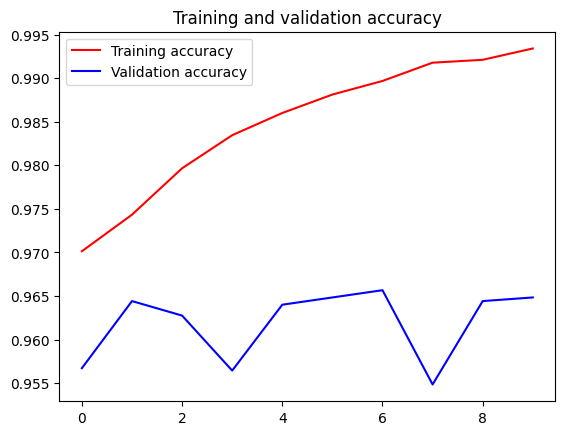

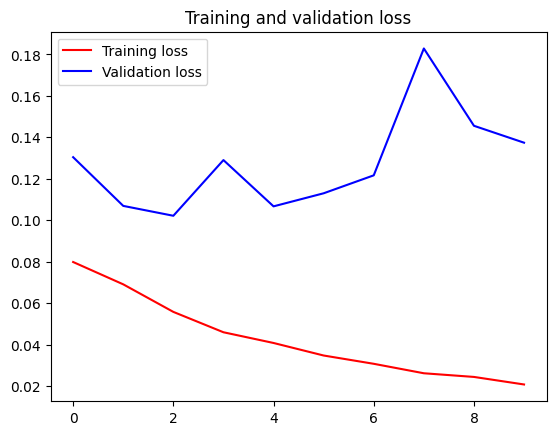

In [16]:
# Plotting the accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()


In [13]:
# Evaluating model on validation data
loss, accuracy = model.evaluate(val_padded, val_labels)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')


451/451 [==============================] - 2s 5ms/step - loss: 0.1374 - accuracy: 0.9648
Validation Loss: 0.1374, Validation Accuracy: 0.9648


In [28]:
# Define function for prediction
def predict_samples(model, tokenizer, texts, actual_labels, n=5, max_length=100):  # Added actual_labels as a parameter
    # Handle the case where 'texts' is a Pandas Series
    if isinstance(texts, pd.Series):
        sample_texts = texts.iloc[:n].tolist()
        sample_labels = actual_labels.iloc[:n].tolist()
    else:
        sample_texts = texts[:n]
        sample_labels = actual_labels[:n]

    # Convert texts to sequences
    sequences = tokenizer.texts_to_sequences(sample_texts)
    # Pad the sequences
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    # Make predictions
    predictions = model.predict(padded_sequences)
    # Convert predictions to class labels
    predicted_labels = ['real news' if pred >= 0.5 else 'fake news' for pred in predictions]

    for i in range(n):
        print(f"Text: {sample_texts[i]}")
        print(f"Predicted Label: {predicted_labels[i]}")
        print(f"Actual Label: {sample_labels[i]}")  # Print the actual label
        print("---"*100)

# Call the function with both val_texts and val_labels (assuming val_labels exists)
predict_samples(model, tokenizer, val_texts, val_labels, n=5, max_length=max_length)

1/1 [==============================] - 0s 20ms/step
Text: Trump s ongoing meltdown over  fake news  (the rest of us call it  reporting) organizations entered what seems like its eighteenth year on Wednesday after NBC correctly reported on the  Today  show that companies like Wal-Mart and General Motors are pulling a fast one on Trump by saying that job creation that was going to happen anyway was because of him in an effort to trick him into liking them.But don t take NBC s word for it.The CEOs of Fiat Chrysler and Ford said job announcements were business decisions and not a result of pressure from Trump https://t.co/lh8MhyoIAf  David Shepardson (@davidshepardson) January 18, 2017Nevertheless, Trump decried any reporting that does not place him as some kind of job creation wizard as  fake news,  the new right-wing term for  facts    in third person, nonetheless.Totally biased @NBCNews went out of its way to say that the big announcement from Ford, G.M., Lockheed & others that jobs are